# Doble pozo

- ¿Crees que podrías representar gráficamente con matplotlib aquí el siguiente potencial externo?

\begin{equation}
V(x)=E_{0}\left[ \left(\frac{x}{a}\right)^4 -2\left(\frac{x}{a}\right)^2 \right]-\frac{b}{a}x
\end{equation}

- ¿Qué interpretación le das a las constantes $E_{0}$, $a$ y $b$?

- Juega a modificar los parámetros del potencial, la temperatura, y la viscosidad.

In [1]:
import openmm as mm
from openmm import app
from openmm import unit
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Definición del sistema.

n_particles = 1
mass = 100 * unit.amu

In [3]:
# Creación del sistema.

system = mm.System()

for ii in range(n_particles):
    system.addParticle(mass)

In [4]:
# Añadiendo el potencial externo al sistema

Eo = 3.0 * unit.kilocalories_per_mole
a = 0.5 * unit.nanometers
b = 0.5 * unit.kilocalories_per_mole
k = 1.0*unit.kilocalories_per_mole/unit.angstrom**2

A = Eo/(a**4)
B = -2.0*Eo/(a**2)
C = -b/a
D = k/2.0

force = mm.CustomExternalForce('A*x^4+B*x^2+C*x + D*(y^2+z^2)')
force.addGlobalParameter('A', A)
force.addGlobalParameter('B', B)
force.addGlobalParameter('C', C)
force.addGlobalParameter('D', D)


for ii in range(n_particles):
    force.addParticle(ii, [])

_ = system.addForce(force)


In [5]:
# Definición del estado termodinámico y el integrador.

step_size = 0.01*unit.picoseconds
temperature = 300*unit.kelvin
friction = 1.0/unit.picosecond # Damping para la dinámica de Langevin

integrator = mm.LangevinIntegrator(temperature, friction, step_size)

**Por favor prueba a remplazar en la siguiente celda 'CPU' por 'CUDA' a ver si corre**

In [6]:
# Creación de la plataforma.

platform_name = 'CPU'
platform = mm.Platform.getPlatformByName(platform_name)

In [7]:
# Creación del contexto.

context = mm.Context(system, integrator, platform)

In [8]:
# Condiciones iniciales

initial_positions  = np.zeros([n_particles, 3], np.float32) * unit.angstroms
initial_positions[0,0] = 5.0 * unit.angstroms

initial_velocities = np.zeros([n_particles, 3], np.float32) * unit.angstroms/unit.picoseconds

context.setPositions(initial_positions)
context.setVelocities(initial_velocities)

In [9]:
# Parámetros de la simulación.

simulation_time = 10.0*unit.nanosecond
saving_time = 1.0*unit.picoseconds

In [10]:
n_steps_per_period = int(saving_time/step_size) # número de pasos del periodo de guardado
n_periods = int(simulation_time/saving_time) # número de periodos guardados

In [11]:
# Creación de arrays reporteros del tiempo, la posición y la velocidad.

times = np.zeros([n_periods], np.float32) * unit.picoseconds
positions = np.zeros([n_periods, n_particles, 3], np.float32) * unit.angstroms
velocities = np.zeros([n_periods, n_particles, 3], np.float32) * unit.angstroms/unit.picosecond
potential_energies   = np.zeros([n_periods], np.float32) * unit.kilocalories_per_mole
kinetic_energies     = np.zeros([n_periods], np.float32) * unit.kilocalories_per_mole

In [12]:
# Almacenamiento en reporteros de las condiciones iniciales para tiempo 0

state = context.getState(getPositions=True, getVelocities=True, getEnergy=True)

times[0] = state.getTime()
positions[0] = state.getPositions()
velocities[0] = state.getVelocities()
kinetic_energies[0]=state.getKineticEnergy()
potential_energies[0]=state.getPotentialEnergy()

In [13]:
# Ejecuto el bucle sobre el número de periodos que vamos a simular

for ii in tqdm(range(1, n_periods)):
    context.getIntegrator().step(n_steps_per_period)
    state = context.getState(getPositions=True, getVelocities=True, getEnergy=True)
    times[ii] = state.getTime()
    positions[ii] = state.getPositions()
    velocities[ii] = state.getVelocities()
    kinetic_energies[ii]=state.getKineticEnergy()
    potential_energies[ii]=state.getPotentialEnergy()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9999/9999 [02:53<00:00, 57.69it/s]


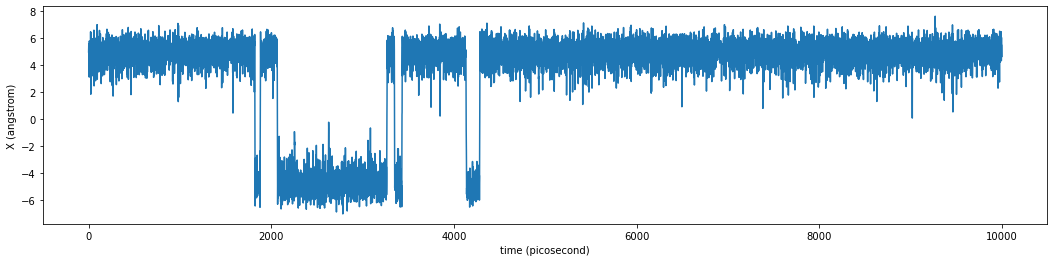

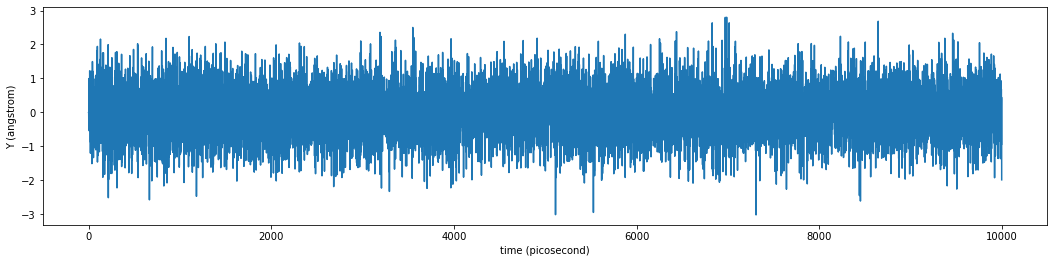

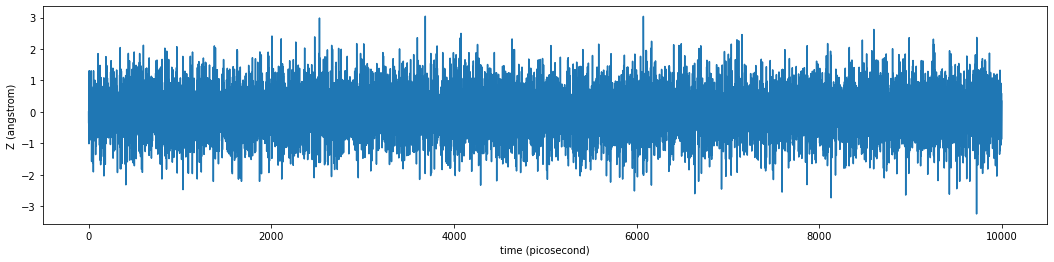

In [14]:
#Graficando las trayectorias en X, Y y Z

plt.rcParams['figure.figsize'] = 18, 4

for ii, axis_label in zip(range(3),['X','Y','Z']):
    plt.plot(times, positions[:,0,ii])
    plt.ylabel('{} ({})'.format(axis_label, positions.unit))
    plt.xlabel('time ({})'.format(times.unit))
    plt.show()

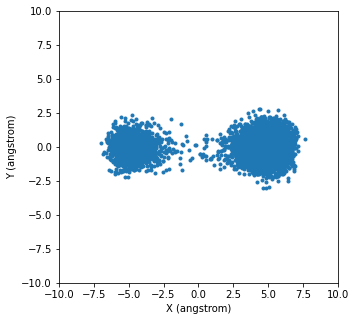

In [15]:
# Viendo la trayectoria en el plano X,Y

plt.rcParams['figure.figsize'] = 5, 5

plt.plot(positions[:,0,0], positions[:,0,1], '.')
plt.xlabel('X ({})'.format(positions.unit))
plt.ylabel('Y ({})'.format(positions.unit))
plt.xlim([-10.0, 10.0])
plt.ylim([-10.0, 10.0])
plt.show()